<a href="https://colab.research.google.com/github/RemyaVKarthikeyan/AA-Stagecoach-Project/blob/main/File_share_48_Cumulative_Arrival_predictions_corrected_with_Headway_calculation_correction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

17/07/2024- correcting the gap of new hr ! = 0.
(modified 47 with cumulative df)    

correcting the following error of the above code 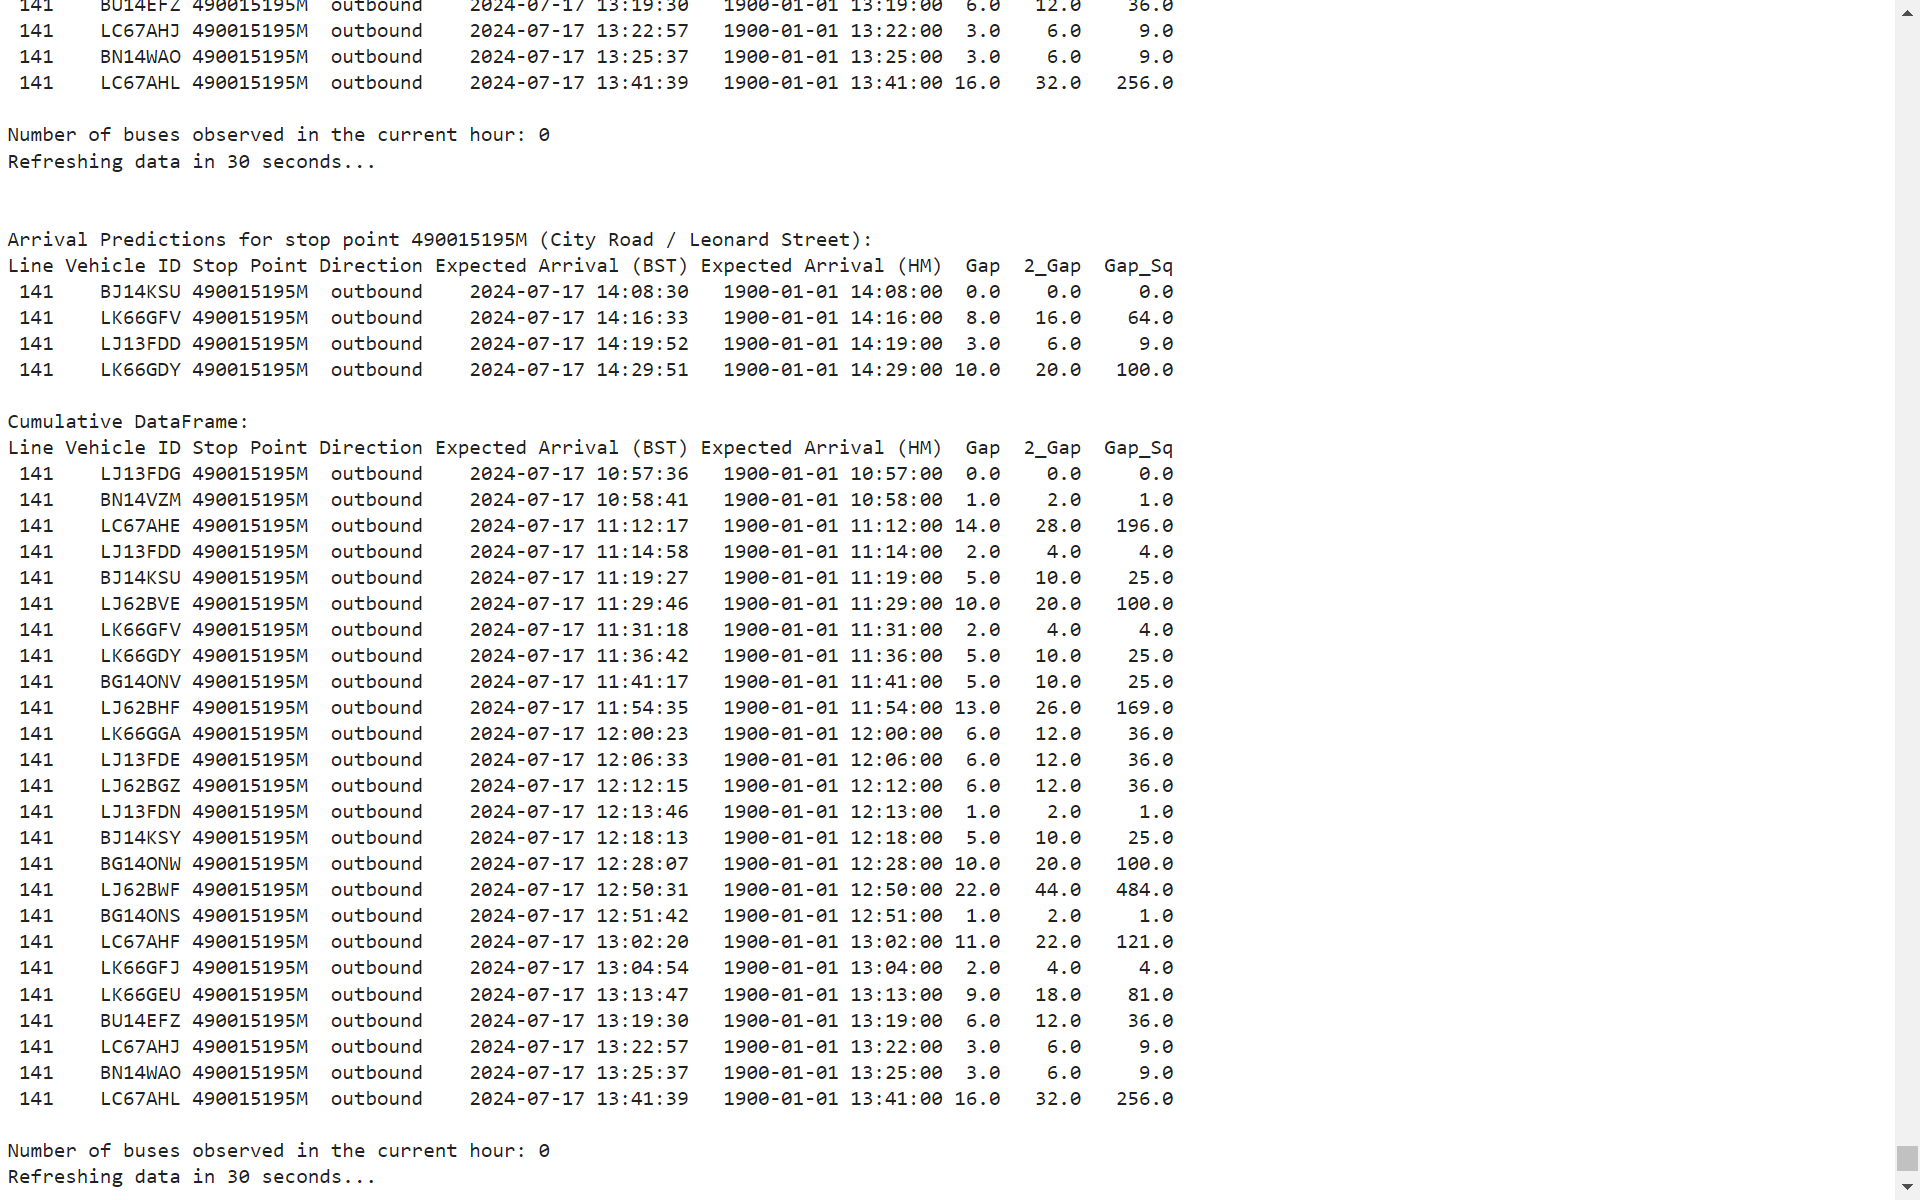![image.png]() (condition to overwrite changed compared to above code)

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import pytz
import time

def fetch_arrival_predictions(line_id, stop_point_id, direction):
    try:
        base_url = f"https://api.tfl.gov.uk/Line/{line_id}/Arrivals/{stop_point_id}"
        params = {'direction': direction}
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        if len(data) == 0:
            return pd.DataFrame(), None  # No data available
        station_name = data[0]['stationName']
        predictions = []
        for item in data:
            arrival_time = datetime.strptime(item['expectedArrival'], '%Y-%m-%dT%H:%M:%SZ')
            arrival_time_bst = arrival_time + timedelta(hours=1)
            predictions.append({
                'Line': item['lineName'],
                'Vehicle ID': item['vehicleId'],
                'Stop Point': stop_point_id,
                'Direction': direction,
                'Expected Arrival (BST)': arrival_time_bst,
                'Expected Arrival (HM)': arrival_time_bst.strftime('%H:%M')
            })
        df = pd.DataFrame(predictions)
        df = df.sort_values(by='Expected Arrival (BST)', ascending=True)
        df['Expected Arrival (BST)'] = pd.to_datetime(df['Expected Arrival (BST)'])  # Convert to datetime
        df['Expected Arrival (HM)'] = pd.to_datetime(df['Expected Arrival (HM)'], format='%H:%M')
        df['Gap'] = df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60
        df['2_Gap'] = (df['Gap'] * 2).round(2)
        df['Gap_Sq'] = (df['Gap'] * df['Gap']).round(2)
        return df, station_name
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None, None

def main():
    line_id = input("Enter Line ID: ")
    stop_point_id = input("Enter Stop Point ID: ")
    direction = input("Enter Direction (inbound/outbound): ")

    cumulative_df = pd.DataFrame(columns=[
        'Line', 'Vehicle ID', 'Stop Point', 'Direction',
        'Expected Arrival (BST)', 'Expected Arrival (HM)',
        'Gap', '2_Gap', 'Gap_Sq'
    ])

    while True:
        arrival_predictions_df, station_name = fetch_arrival_predictions(line_id, stop_point_id, direction)

        if arrival_predictions_df is not None and not arrival_predictions_df.empty:
            current_hour = datetime.now(pytz.timezone('Europe/London')).hour
            next_hour = (current_hour + 1) % 24

            for _, row in arrival_predictions_df.iterrows():
                vehicle_id = row['Vehicle ID']
                expected_hour = row['Expected Arrival (BST)'].hour

                # Check if vehicle_id already exists in cumulative_df
                mask = cumulative_df['Vehicle ID'] == vehicle_id

                if cumulative_df[mask].empty:
                    # If vehicle_id is new, append the row
                    cumulative_df = pd.concat([cumulative_df, row.to_frame().T], ignore_index=True)
                else:
                    # Vehicle_id already exists, check expected arrival time criteria
                    existing_hour = cumulative_df.loc[mask, 'Expected Arrival (BST)'].iloc[0].hour

                    if expected_hour > existing_hour + 1:
                        # Append the row if new expected arrival hour is greater than (existing_hour + 1)
                        cumulative_df = pd.concat([cumulative_df, row.to_frame().T], ignore_index=True)
                    else:
                        # Overwrite the row if new expected arrival hour is <= (existing_hour + 1)
                        cumulative_df.loc[mask, ['Line', 'Stop Point', 'Direction', 'Expected Arrival (BST)', 'Expected Arrival (HM)', 'Gap', '2_Gap', 'Gap_Sq']] = row[['Line', 'Stop Point', 'Direction', 'Expected Arrival (BST)', 'Expected Arrival (HM)', 'Gap', '2_Gap', 'Gap_Sq']].values

            # Recalculate headway for cumulative_df
            cumulative_df = cumulative_df.sort_values(by='Expected Arrival (BST)', ascending=True)
            cumulative_df['Expected Arrival (BST)'] = pd.to_datetime(cumulative_df['Expected Arrival (BST)'])  # Ensure datetime format
            cumulative_df['Expected Arrival (HM)'] = pd.to_datetime(cumulative_df['Expected Arrival (HM)'], format='%H:%M')

            cumulative_df['Gap'] = cumulative_df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60
            cumulative_df['2_Gap'] = (cumulative_df['Gap'] * 2).round(2)
            cumulative_df['Gap_Sq'] = (cumulative_df['Gap'] * cumulative_df['Gap']).round(2)

            # Calculate the number of buses observed in the current hour
            num_buses_observed = cumulative_df[cumulative_df['Expected Arrival (BST)'].dt.hour == current_hour].shape[0]

            print(f"\nArrival Predictions for stop point {stop_point_id} ({station_name}):")
            print(arrival_predictions_df.to_string(index=False))
            print("\nCumulative DataFrame:")
            print(cumulative_df.to_string(index=False))
            print(f"\nNumber of buses observed in the current hour: {num_buses_observed}")
        else:
            print("No arrival predictions available.")

        print("Refreshing data in 30 seconds...\n")
        time.sleep(30)  # Wait for 30 seconds before fetching data again

if __name__ == "__main__":
    main()


Enter Line ID: 141
Enter Stop Point ID: 490015195M
Enter Direction (inbound/outbound): outbound

Arrival Predictions for stop point 490015195M (City Road / Leonard Street):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 141    LC67AHF 490015195M  outbound    2024-07-17 15:48:36   1900-01-01 15:48:00  0.0    0.0     0.0
 141    LK66GEJ 490015195M  outbound    2024-07-17 15:59:56   1900-01-01 15:59:00 11.0   22.0   121.0
 141    LK66GFJ 490015195M  outbound    2024-07-17 16:03:21   1900-01-01 16:03:00  4.0    8.0    16.0
 141    LK66GEU 490015195M  outbound    2024-07-17 16:06:01   1900-01-01 16:06:00  3.0    6.0     9.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 141    LC67AHF 490015195M  outbound    2024-07-17 15:48:36   1900-01-01 15:48:00  0.0    0.0     0.0
 141    LK66GEJ 490015195M  outbound    2024-07-17 15:59:56   1900-01-01 15:59:00 11.0   2

KeyboardInterrupt: 

making code work for few stop pint ids

In [3]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import pytz
import time

def fetch_arrival_predictions(line_id, stop_point_id, direction):
    try:
        base_url = f"https://api.tfl.gov.uk/Line/{line_id}/Arrivals/{stop_point_id}"
        params = {'direction': direction}
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        if len(data) == 0:
            return pd.DataFrame(), None  # No data available
        station_name = data[0]['stationName']
        predictions = []
        for item in data:
            arrival_time = datetime.strptime(item['expectedArrival'], '%Y-%m-%dT%H:%M:%SZ')
            arrival_time_bst = arrival_time + timedelta(hours=1)
            predictions.append({
                'Line': item['lineName'],
                'Vehicle ID': item['vehicleId'],
                'Stop Point': stop_point_id,
                'Direction': direction,
                'Expected Arrival (BST)': arrival_time_bst,
                'Expected Arrival (HM)': arrival_time_bst.strftime('%H:%M')
            })
        df = pd.DataFrame(predictions)
        df = df.sort_values(by='Expected Arrival (BST)', ascending=True)
        df['Expected Arrival (BST)'] = pd.to_datetime(df['Expected Arrival (BST)'])  # Convert to datetime
        df['Expected Arrival (HM)'] = pd.to_datetime(df['Expected Arrival (HM)'], format='%H:%M')
        df['Gap'] = df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60
        df['2_Gap'] = (df['Gap'] * 2).round(2)
        df['Gap_Sq'] = (df['Gap'] * df['Gap']).round(2)
        return df, station_name
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None, None

def main():
    try:
        line_id = input("Enter Line ID: ")
        stop_point_ids = input("Enter Stop Point IDs (comma-separated): ").split(',')
        directions = input("Enter Directions (comma-separated, e.g., inbound,outbound): ").split(',')

        cumulative_df = pd.DataFrame(columns=[
            'Line', 'Vehicle ID', 'Stop Point', 'Direction',
            'Expected Arrival (BST)', 'Expected Arrival (HM)',
            'Gap', '2_Gap', 'Gap_Sq'
        ])

        while True:
            for stop_point_id in stop_point_ids:
                for direction in directions:
                    arrival_predictions_df, station_name = fetch_arrival_predictions(line_id, stop_point_id.strip(), direction.strip())

                    if arrival_predictions_df is not None and not arrival_predictions_df.empty:
                        current_hour = datetime.now(pytz.timezone('Europe/London')).hour
                        next_hour = (current_hour + 1) % 24

                        for _, row in arrival_predictions_df.iterrows():
                            vehicle_id = row['Vehicle ID']
                            expected_hour = row['Expected Arrival (BST)'].hour

                            # Check if vehicle_id already exists in cumulative_df
                            mask = cumulative_df['Vehicle ID'] == vehicle_id

                            if cumulative_df[mask].empty:
                                # If vehicle_id is new, append the row
                                cumulative_df = pd.concat([cumulative_df, row.to_frame().T], ignore_index=True)
                            else:
                                # Vehicle_id already exists, check expected arrival time criteria
                                existing_hour = cumulative_df.loc[mask, 'Expected Arrival (BST)'].iloc[0].hour

                                if expected_hour > existing_hour + 1:
                                    # Append the row if new expected arrival hour is greater than (existing_hour + 1)
                                    cumulative_df = pd.concat([cumulative_df, row.to_frame().T], ignore_index=True)
                                else:
                                    # Overwrite the row if new expected arrival hour is <= (existing_hour + 1)
                                    cumulative_df.loc[mask, ['Line', 'Stop Point', 'Direction', 'Expected Arrival (BST)', 'Expected Arrival (HM)', 'Gap', '2_Gap', 'Gap_Sq']] = row[['Line', 'Stop Point', 'Direction', 'Expected Arrival (BST)', 'Expected Arrival (HM)', 'Gap', '2_Gap', 'Gap_Sq']].values

                        # Recalculate headway for cumulative_df
                        cumulative_df = cumulative_df.sort_values(by='Expected Arrival (BST)', ascending=True)
                        cumulative_df['Expected Arrival (BST)'] = pd.to_datetime(cumulative_df['Expected Arrival (BST)'])  # Ensure datetime format
                        cumulative_df['Expected Arrival (HM)'] = pd.to_datetime(cumulative_df['Expected Arrival (HM)'], format='%H:%M')

                        cumulative_df['Gap'] = cumulative_df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60
                        cumulative_df['2_Gap'] = (cumulative_df['Gap'] * 2).round(2)
                        cumulative_df['Gap_Sq'] = (cumulative_df['Gap'] * cumulative_df['Gap']).round(2)

                        # Calculate the number of buses observed in the current hour
                        num_buses_observed = cumulative_df[cumulative_df['Expected Arrival (BST)'].dt.hour == current_hour].shape[0]

                        print(f"\nArrival Predictions for stop point {stop_point_id} ({station_name}), Direction: {direction}:")
                        print(arrival_predictions_df.to_string(index=False))
                        print("\nCumulative DataFrame:")
                        print(cumulative_df.to_string(index=False))
                        print(f"\nNumber of buses observed in the current hour: {num_buses_observed}")
                    else:
                        print(f"No arrival predictions available for stop point {stop_point_id}, Direction: {direction}.")

            print("Refreshing data in 30 seconds...\n")
            time.sleep(30)  # Wait for 30 seconds before fetching data again

    except KeyboardInterrupt:
        print("\nProgram terminated by user.")

if __name__ == "__main__":
    main()


Enter Line ID: 22
Enter Stop Point IDs (comma-separated): 490012375E,490008435E,490005156W,490015145E
Enter Directions (comma-separated, e.g., inbound,outbound): outbound, outbound, outbound, outbound

Arrival Predictions for stop point 490012375E (Commondale), Direction: outbound:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
  22    BV66VHT 490012375E  outbound    2024-07-17 17:36:28   1900-01-01 17:36:00  0.0    0.0     0.0
  22    BV66VHW 490012375E  outbound    2024-07-17 17:49:10   1900-01-01 17:49:00 13.0   26.0   169.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
  22    BV66VHT 490012375E  outbound    2024-07-17 17:36:28   1900-01-01 17:36:00  0.0    0.0     0.0
  22    BV66VHW 490012375E  outbound    2024-07-17 17:49:10   1900-01-01 17:49:00 13.0   26.0   169.0

Number of buses observed in the current hour: 2

Arrival Predictions for stop poi

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import pytz
import time

def fetch_arrival_predictions(line_id, stop_point_id, direction):
    try:
        base_url = f"https://api.tfl.gov.uk/Line/{line_id}/Arrivals/{stop_point_id}"
        params = {'direction': direction}
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        if len(data) == 0:
            return pd.DataFrame(), None  # No data available
        station_name = data[0]['stationName']
        predictions = []
        for item in data:
            arrival_time = datetime.strptime(item['expectedArrival'], '%Y-%m-%dT%H:%M:%SZ')
            arrival_time_bst = arrival_time + timedelta(hours=1)
            predictions.append({
                'Line': item['lineName'],
                'Vehicle ID': item['vehicleId'],
                'Stop Point': stop_point_id,
                'Direction': direction,
                'Expected Arrival (BST)': arrival_time_bst,
                'Expected Arrival (HM)': arrival_time_bst.strftime('%H:%M')
            })
        df = pd.DataFrame(predictions)
        df = df.sort_values(by='Expected Arrival (BST)', ascending=True)
        df['Expected Arrival (BST)'] = pd.to_datetime(df['Expected Arrival (BST)'])  # Convert to datetime
        df['Expected Arrival (HM)'] = pd.to_datetime(df['Expected Arrival (HM)'], format='%H:%M')
        df['Gap'] = df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60
        df['2_Gap'] = (df['Gap'] * 2).round(2)
        df['Gap_Sq'] = (df['Gap'] * df['Gap']).round(2)
        return df, station_name
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None, None

def process_stop_point(line_id, stop_point_id, direction):
    cumulative_df = pd.DataFrame(columns=[
        'Line', 'Vehicle ID', 'Stop Point', 'Direction',
        'Expected Arrival (BST)', 'Expected Arrival (HM)',
        'Gap', '2_Gap', 'Gap_Sq'
    ])

    try:
        while True:
            arrival_predictions_df, station_name = fetch_arrival_predictions(line_id, stop_point_id, direction)

            if arrival_predictions_df is not None and not arrival_predictions_df.empty:
                current_hour = datetime.now(pytz.timezone('Europe/London')).hour

                for _, row in arrival_predictions_df.iterrows():
                    vehicle_id = row['Vehicle ID']
                    expected_hour = row['Expected Arrival (BST)'].hour

                    # Check if vehicle_id already exists in cumulative_df
                    mask = cumulative_df['Vehicle ID'] == vehicle_id

                    if cumulative_df[mask].empty:
                        # If vehicle_id is new, append the row
                        cumulative_df = pd.concat([cumulative_df, row.to_frame().T], ignore_index=True)
                    else:
                        # Vehicle_id already exists, check expected arrival time criteria
                        existing_hour = cumulative_df.loc[mask, 'Expected Arrival (BST)'].iloc[0].hour

                        if expected_hour > existing_hour + 1:
                            # Append the row if new expected arrival hour is greater than (existing_hour + 1)
                            cumulative_df = pd.concat([cumulative_df, row.to_frame().T], ignore_index=True)
                        else:
                            # Overwrite the row if new expected arrival hour is <= (existing_hour + 1)
                            cumulative_df.loc[mask, ['Line', 'Stop Point', 'Direction', 'Expected Arrival (BST)', 'Expected Arrival (HM)', 'Gap', '2_Gap', 'Gap_Sq']] = row[['Line', 'Stop Point', 'Direction', 'Expected Arrival (BST)', 'Expected Arrival (HM)', 'Gap', '2_Gap', 'Gap_Sq']].values

                # Recalculate headway for cumulative_df
                cumulative_df = cumulative_df.sort_values(by='Expected Arrival (BST)', ascending=True)
                cumulative_df['Expected Arrival (BST)'] = pd.to_datetime(cumulative_df['Expected Arrival (BST)'])  # Ensure datetime format
                cumulative_df['Expected Arrival (HM)'] = pd.to_datetime(cumulative_df['Expected Arrival (HM)'], format='%H:%M')

                cumulative_df['Gap'] = cumulative_df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60
                cumulative_df['2_Gap'] = (cumulative_df['Gap'] * 2).round(2)
                cumulative_df['Gap_Sq'] = (cumulative_df['Gap'] * cumulative_df['Gap']).round(2)

                # Calculate the number of buses observed in the current hour
                num_buses_observed = cumulative_df[cumulative_df['Expected Arrival (BST)'].dt.hour == current_hour].shape[0]

                print(f"\nArrival Predictions for stop point {stop_point_id} ({station_name}), Direction: {direction}:")
                print(arrival_predictions_df.to_string(index=False))
                print("\nCumulative DataFrame:")
                print(cumulative_df.to_string(index=False))
                print(f"\nNumber of buses observed in the current hour: {num_buses_observed}")
            else:
                print(f"No arrival predictions available for stop point {stop_point_id}, Direction: {direction}.")

            print("Refreshing data in 30 seconds...\n")
            time.sleep(30)  # Wait for 30 seconds before fetching data again

    except KeyboardInterrupt:
        print("\nProgram terminated by user.")

def main():
    try:
        line_id = input("Enter Line ID: ")
        stop_point_ids = input("Enter Stop Point IDs (comma-separated): ").split(',')
        directions = input("Enter Directions (comma-separated, e.g., inbound,outbound): ").split(',')

        for stop_point_id in stop_point_ids:
            for direction in directions:
                process_stop_point(line_id, stop_point_id.strip(), direction.strip())

    except KeyboardInterrupt:
        print("\nProgram terminated by user.")

if __name__ == "__main__":
    main()


Streaming output truncated to the last 5000 lines.
  22    LJ62KGN 490012375E  outbound    2024-07-17 17:59:28   1900-01-01 17:59:00 10.0   20.0   100.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
  22    BV66VHT 490012375E  outbound    2024-07-17 17:37:11   1900-01-01 17:37:00  0.0    0.0     0.0
  22    BV66VHW 490012375E  outbound    2024-07-17 17:49:10   1900-01-01 17:49:00 12.0   24.0   144.0
  22    LJ62KGN 490012375E  outbound    2024-07-17 17:59:28   1900-01-01 17:59:00 10.0   20.0   100.0

Number of buses observed in the current hour: 3
Refreshing data in 30 seconds...


Arrival Predictions for stop point 490012375E (Commondale), Direction: outbound:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
  22    BV66VHW 490012375E  outbound    2024-07-17 17:49:10   1900-01-01 17:49:00  0.0    0.0     0.0
  22    LJ62KGN 490012375E  outbound    2024-07

above code taking only first stoppoint id and direction and iterating through that only.